# Is seasonality a good predictor of implied volatility?

### Testing Seasonality functions

First, we need to define seasonality. We're going to create a few "seasonality" parameters using either sinusoidal functions or a linear interpretation. We've selected July 2nd as peak seasonality for the initial testing. The initial operating theory is that the best model for seasonality of implied volatility is a sine curve. 

In this model, the relative distance from peak seasonlaity is what matters, not the date within a calendar year. For example, if July 1st is (on average) the maximum implied volatility during the year, both April 1st and October 1st should have similar implied vol averages and thus "seasonality" as we have defined it.

In [127]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import timeit

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

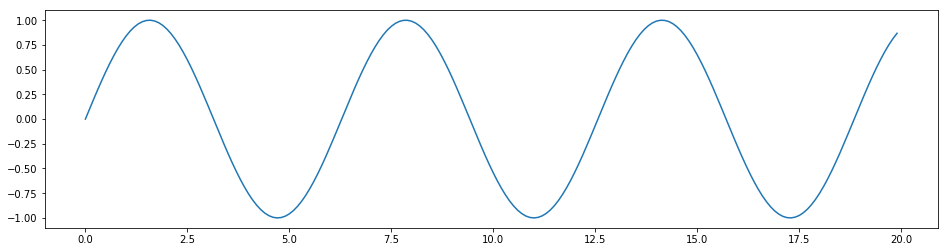

In [198]:
#plot basic sine wave for expected seasonality
x = np.arange(0,20,.1)
y = np.sin(x)
plt.figure(figsize=(16,4))
plt.plot(x,y)
plt.show()

In [183]:
# double check function for max/min amplitude
print("Max Amplitude: ", np.sin(np.pi/2))
print("Min Amplitude:", np.sin(-np.pi/2))

Max Amplitude:  1.0
Min Amplitude: -1.0


#### Below we establish our three seasonality functions

In a given run through this sheet, only one seasonality function should be enabled. Disable and enable each function by highlighting that function's code (starting with `def date_season...`) and press `CTRL + /`

In [188]:
# SINE SEASONALITY FUNCTION 
# define one possible seasonality function we will be using, this one will use the sine function from numpy,
# where seasonality is the number of days from beginning of year * 2pi / number of days in year
# establishes both minimum seasonality and maximum seasonality, which may not be necessary
 
# def date_season(date):
#     year = date.year
#     min_season = pd.datetime(year,1,1)
#     max_season = pd.datetime(year,7,2)
#     dif = abs(max_season - date)
#     dif_days = dif.days
#     x = (((max_season - min_season).days) - dif.days * 2) / (max_season - min_season).days
#     seasonality = np.sin(x * (np.pi) / 2)
#     return(seasonality)

In [189]:
# COSINE SEASONALITY FUNCTION
# define one possible seasonality function we will be using, this one will use the cosine function from numpy
# line in triple quotes creates docstring for notation, must be at start of function and in triple quotes,
# can be multiple lines usually used to explain unique nature of inputs and outputs

# def date_season(date):
#     """
#     computes seasonality parameter.  date should be pd.datetime
#     """
#     year = date.year
#     max_season = pd.datetime(year,7,2) 
#     dif = date - max_season
#     dif_days = dif.days
#     day_count = (pd.datetime(year + 1, 1, 1) - pd.datetime(year, 1, 1)).days
#     x = (dif_days / (day_count)) * (2 * np.pi)
#     seasonality = np.cos(x)
#     return(seasonality)

In [190]:
# LINEAR SEASONALITY FUNCTION
# define one possible seasonality function we will be using, this one will use a linear interpretation
# this avoids clustering of implied vol data near -1.0 & +1.0 seasonality

def date_season(date):
    """
    computes seasonality parameter.  date should be pd.datetime
    """
    year = date.year
    max_season = pd.datetime(year,7,2) 
    dif = date - max_season
    dif_days = dif.days
    day_count = (pd.datetime(year + 1, 1, 1) - pd.datetime(year, 1, 1)).days
    seasonality = 1 - (abs(dif_days) / day_count) * 2
    return(seasonality)

In [191]:
# creates a range of dates to test mapping of the seasonality function

start = dt.date(2017,1,1)
end = dt.date(2019,12,31)
df = pd.DataFrame({'Date': pd.date_range(start, end, freq="D")})

# works because there is only one column in the df we previously created, 
# will throw an error if run twice
df['Seasonality'] = df.applymap(lambda x: date_season(x))

# check to see if seasonality parameter was mapped properly
df.head()

,Date,Seasonality
0,2017-01-01,0.002740
1,2017-01-02,0.008219
2,2017-01-03,0.013699
3,2017-01-04,0.019178
4,2017-01-05,0.024658


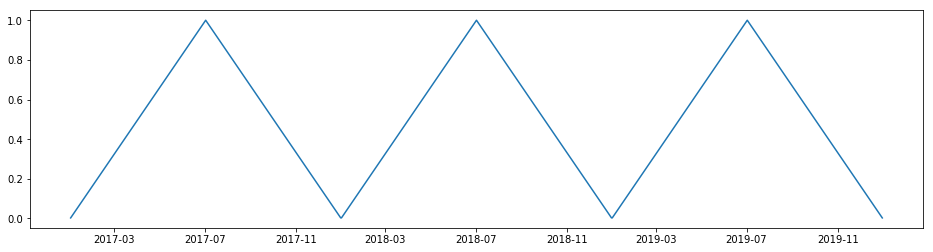

In [197]:
# checks plot of seasonality vs date. Should be a sine wave or triangular pattern
# based on which seasonality function is used

plt.figure(figsize=(16,4))
plt.plot(df['Date'],df['Seasonality'])

### In the section below, we aggregate implied volatility data into a data frame.

In order to test our initial hypothesis, we need to pull some implied vol data and aggregate it into a single dataframe. We are using CSV files exported from a subscription webstie. Next, we need to set a range of days-to-expiration that we want to study, and drop any data not related to implied vol or that DTE range. Finally, we plot that data and view a histogram of the seasonality buckets to see how it is distributed.

In [10]:
# create custom function to wrap up data cleaning work on vol csv files
# its primary purpose is to take a CSV file and convert it to only the front month vols
# doesnt need to be generalized

# add docstring for this function

def front_vol_pull(csv, min_dte, max_dte, obs_id='Observation Date',
                   vol_id='result', title_id='Stat', exp_id='exp_date0', 
                   location='C:/Users/Trader/Desktop/Dropbox/Data Science/DataSets/ImpVol/'):
    """
    csv input must be a .CSV file. location must be a full file location. min_dte & max_dte must be integers.
    """
    
    # read in csv file from location and csv input
    df = pd.read_csv(location+csv, index_col=False)
    
    #converts 'Observation Date' column from string to pandas datetime object
    df[obs_id] = pd.to_datetime(df[obs_id])
    
    # creates new dataframes, one with vol data and one with expiry dates
    dfvols = df.loc[df[title_id] == vol_id]
    dfexp = df.loc[df[title_id] == exp_id]
    
    # rename dat column in vol dataframe to 'Vol'
    dfvols.rename(columns={'Value':'Vol'}, inplace=True)
    
    # create truncated version of SFexp containing just the observation date and the expiry
    # promote the 'Observation Date' & 'Year' column to the multi-index of the dataframe
    # need to use multi-index to join with other dataframes
    dfexp_trunc = dfexp[[obs_id, 'Year', 'Value']]
    dfexp_trunc = dfexp_trunc.set_index([obs_id, 'Year'])
    
    # join the two dataframes on the multi-index of 'Observation Date' & 'Year'
    dfvols_exp = dfvols.join(dfexp_trunc, on=[obs_id, 'Year'])
    
    # remove 'Stat' column and rename 'Value' to 'Expiry', could be moved up a few lines
    del dfvols_exp[title_id]
    dfvols_exp.rename(columns={'Value':'Expiry'}, inplace=True)
    
    # converts 'Expiry' data to a pandas datetime object
    dfvols_exp['Expiry'] = pd.to_datetime(dfvols_exp['Expiry'])
    
    # creates new column with Days to Expiration as a timedelta
    dfvols_exp['DTE'] = dfvols_exp['Expiry'] - dfvols_exp[obs_id]
    
    # converts dte inputs to timedelta objects and creates new dataframe with filtered dates
    max_dte = pd.Timedelta(days=max_dte)
    min_dte = pd.Timedelta(days=min_dte)
    df_fronts = dfvols_exp[(dfvols_exp['DTE'] <= max_dte) & (dfvols_exp['DTE'] > min_dte)]
    
    #df_fronts.set_index(obs_id, inplace=True)
    #print(df_fronts.head())
    return df_fronts

From here, we want to use the custom front_vol_pull function on a list of csv files containing implied volatility data.

In [11]:
# create list of vol files

vol_files = ['SFvol.csv','SHvol.csv','SKvol.csv','SNvol.csv','SQvol.csv','SUvol.csv','SXvol.csv']

In [12]:
# create one large df with all data

# create a list of dataframes and concatenate them at the end of the process

full_data_set = pd.DataFrame()

tic = timeit.default_timer()

for i in vol_files:
    df = front_vol_pull(i,5,60)
    full_data_set = full_data_set.append(df)
    
toc = timeit.default_timer()
print(toc-tic)


C:\Users\Trader\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


39.99026290500001


In [13]:
# sort full_data_set based on DTE, drop entries with observation date overlap, keep shortest DTE
# resort by 'Observation Date' for better clarity, redefine as final_data

# try to move into grand function

full_data_set = full_data_set.sort_values('DTE').drop_duplicates('Observation Date', keep='first')
full_data_set = full_data_set.sort_values('Observation Date')

final_data = full_data_set

In [14]:
# convert values in 'Vol' column from string to float
# map seasonality value to observation date

final_data['Vol'] =  final_data['Vol'].astype(float)
final_data['Seasonality'] = final_data.apply(lambda x: date_season(x['Observation Date']), axis=1 )

In [15]:
print(len(final_data))
final_data.head()

2372


,Observation Date,Year,Vol,Expiry,DTE,Seasonality
15,2009-01-02,2009,41.439999,2009-02-20,49 days,0.008219
32,2009-01-05,2009,41.939999,2009-02-20,46 days,0.024658
49,2009-01-06,2009,43.059999,2009-02-20,45 days,0.030137
66,2009-01-07,2009,42.179999,2009-02-20,44 days,0.035616
83,2009-01-08,2009,40.659999,2009-02-20,43 days,0.041096


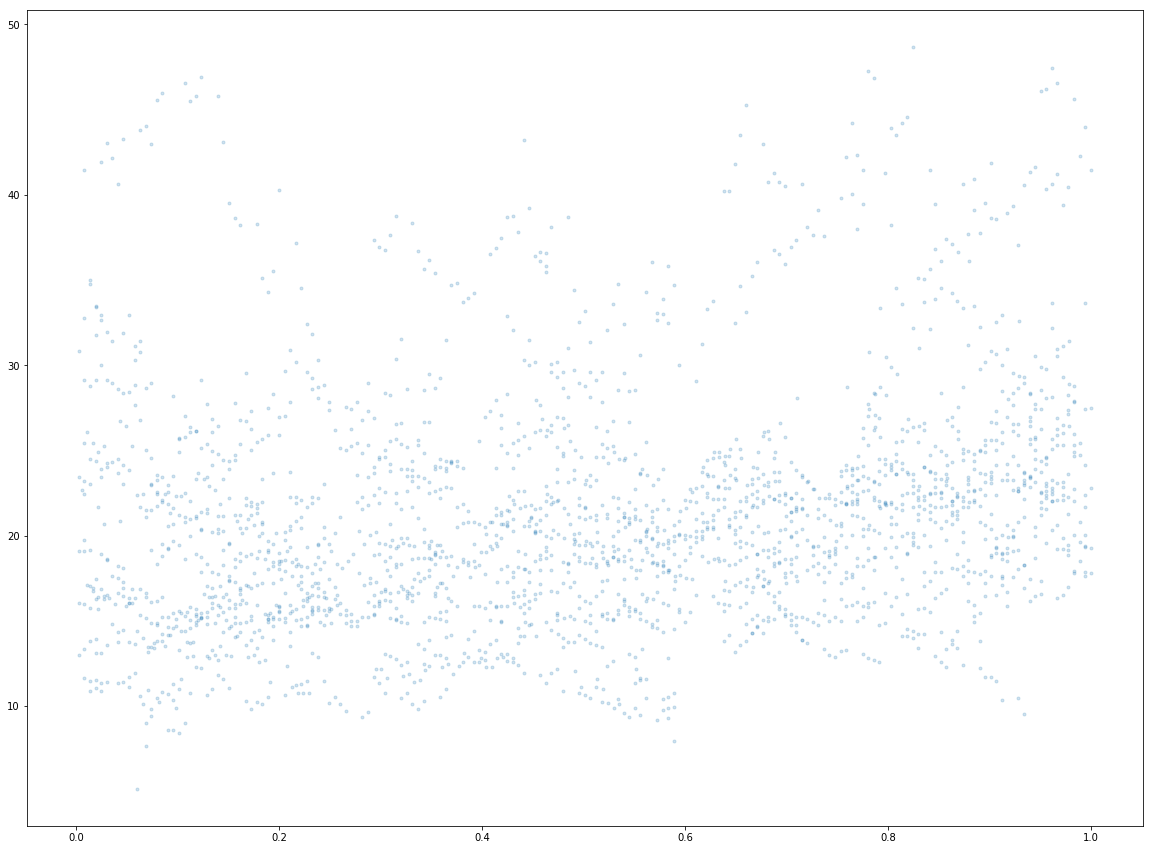

In [16]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000008EEE240>]],
      dtype=object)

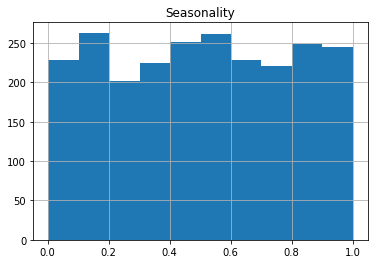

In [17]:
final_data.hist(column='Seasonality', bins=10)

Below, we attempt to fit a curve to our vol/seasonality data with a sigmoid function

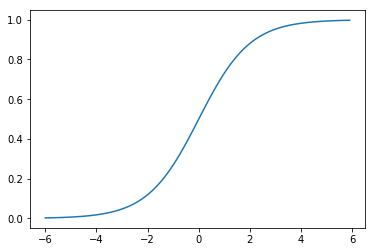

In [18]:
# create an array of numbers -6.0 to +6.0 and plot the sigmoid function using that array as input

x = np.arange(-6.0,6.0,0.1)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)

In [19]:
# define the sigmoid function that will be used in scipy.curve_fit
# this can be substituted with scipy.special.expit(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [20]:
# define our function to fit the sigmoid curve to our vol data with a k variable, min vol, and range

def sig_fit(x, k, breadth, minimum):
    return (1 / (1 + np.exp(-x*k)) * breadth) + minimum

In [21]:
print(sig_fit(0,0.5,20,10))
print(sig_fit(0,0.21,40.37,1.0))

20.0
21.185


In [22]:
xdata = final_data['Seasonality']
ydata = final_data['Vol']

#forced parameters to display nice sigmoid curve, straight line without
# the nature of seasonality sine curve might be offsetting expected result
# if seasonality was linear, the optimal curve might more reflect the sigmoid we expected
popt, pcov = curve_fit(sig_fit, xdata, ydata, bounds=([-4,-1000,-2500],[4,1000,2500]))

print(popt)
print(pcov)

[ 3.47410482e-02  6.00367801e+02 -2.81609650e+02]
[[ 1.64167823e+03 -2.83650507e+07  1.41825154e+07]
 [-2.83650507e+07  4.90093669e+11 -2.45046661e+11]
 [ 1.41825154e+07 -2.45046661e+11  1.22523244e+11]]


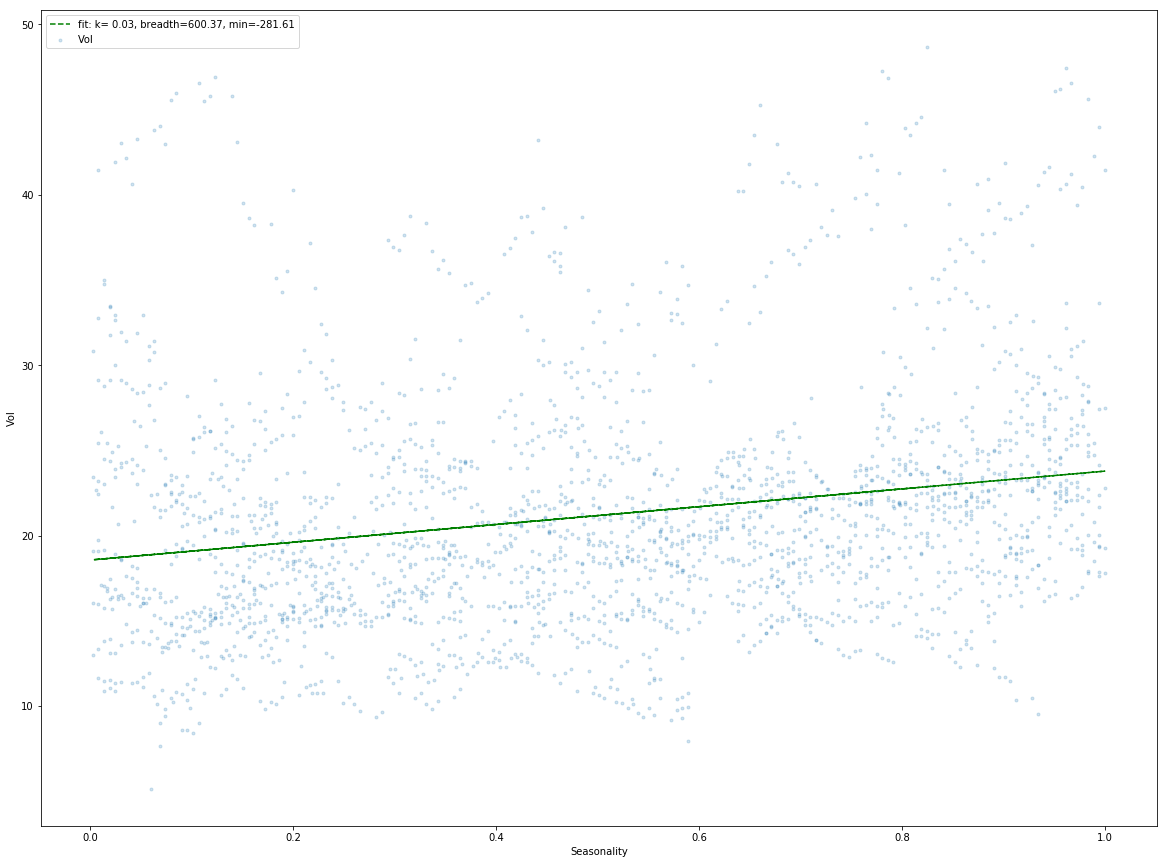

In [23]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, sig_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.ylabel('Vol')
plt.xlabel('Seasonality')
plt.legend()
plt.show()

### Creating a more reasonable model

In [24]:
print(final_data)

      Observation Date  Year        Vol     Expiry     DTE  Seasonality
15          2009-01-02  2009  41.439999 2009-02-20 49 days     0.008219
32          2009-01-05  2009  41.939999 2009-02-20 46 days     0.024658
49          2009-01-06  2009  43.059999 2009-02-20 45 days     0.030137
66          2009-01-07  2009  42.179999 2009-02-20 44 days     0.035616
83          2009-01-08  2009  40.659999 2009-02-20 43 days     0.041096
100         2009-01-09  2009  43.259999 2009-02-20 42 days     0.046575
117         2009-01-12  2009  43.779999 2009-02-20 39 days     0.063014
134         2009-01-13  2009  44.039999 2009-02-20 38 days     0.068493
151         2009-01-14  2009  42.999999 2009-02-20 37 days     0.073973
168         2009-01-15  2009  45.559999 2009-02-20 36 days     0.079452
185         2009-01-16  2009  45.959999 2009-02-20 35 days     0.084932
202         2009-01-20  2009  46.539999 2009-02-20 31 days     0.106849
219         2009-01-21  2009  45.519999 2009-02-20 30 days     0

In [25]:
recent_data = final_data[final_data['Year'] > 2014]

In [26]:
print(recent_data.head())
print(recent_data.min())
print(recent_data.max())

      Observation Date  Year        Vol     Expiry     DTE  Seasonality
22863       2014-10-27  2015  22.719999 2014-12-25 59 days     0.358904
22880       2014-10-28  2015  23.939999 2014-12-25 58 days     0.353425
22897       2014-10-29  2015  26.699999 2014-12-25 57 days     0.347945
22914       2014-10-30  2015  26.679999 2014-12-25 56 days     0.342466
22931       2014-10-31  2015  25.639999 2014-12-25 55 days     0.336986
Observation Date    2014-10-27 00:00:00
Year                               2015
Vol                                7.66
Expiry              2014-12-25 00:00:00
DTE                     6 days 00:00:00
Seasonality                  0.00273973
dtype: object
Observation Date    2019-05-29 00:00:00
Year                               2019
Vol                                32.6
Expiry              2019-06-26 00:00:00
DTE                    60 days 00:00:00
Seasonality                           1
dtype: object


In [66]:
xdata = recent_data['Seasonality']
ydata = recent_data['Vol']

popt, pcov = curve_fit(sig_fit, xdata, ydata, bounds=([0, 0, 0], [10, 40, 40]))

print(popt)
print(pcov)

[9.39990485e-01 2.87083014e+01 5.17293418e-12]
[[   1.6025628   -43.05119846   21.23905349]
 [ -43.05119846 1160.61037531 -573.05634428]
 [  21.23905349 -573.05634428  283.02119026]]


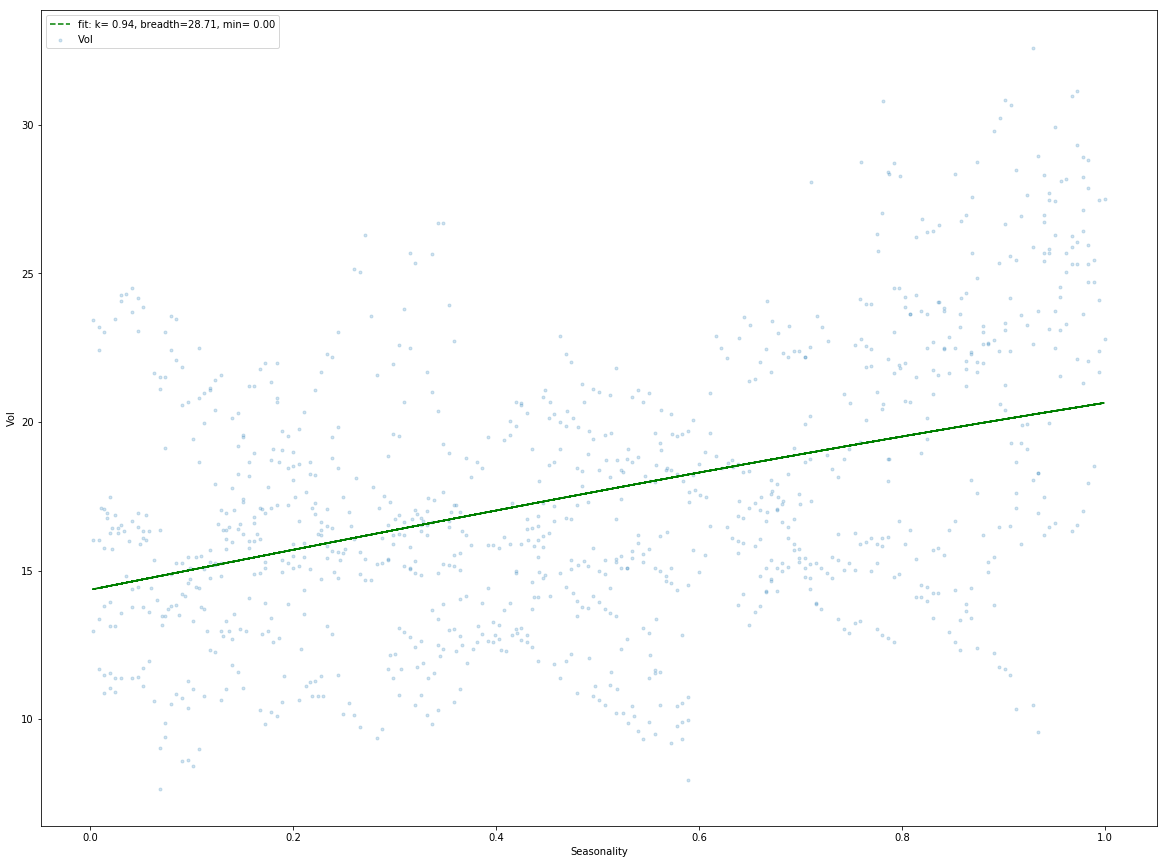

In [28]:
plt.figure(figsize=(20,15))
plt.scatter(recent_data['Seasonality'], recent_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, sig_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.ylabel('Vol')
plt.xlabel('Seasonality')
plt.legend()
plt.show()

Despite limiting the data to the most recent 5 years, we still see a very linear relationship between seasonality and implied volatility

Below we attepmt to fit an arc tangent function

In [29]:
def arc_fit(x, k, breadth, minimum):
    return (np.arctan(x*k) * breadth) + minimum

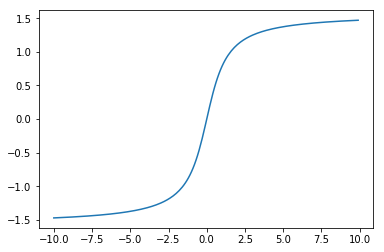

In [30]:
x = np.arange(-10,10,.1)
y = np.arctan(x)
plt.plot(x,y)
plt.show()

In [31]:
print(arc_fit(3.14/2,1,1,0))
print(arc_fit(0.5,1,10,0))

1.0036550779803273
4.636476090008061


In [32]:
popt, pcov = curve_fit(arc_fit, xdata, ydata, bounds=([0, 0, 0], [10, 40, 50]))

print(popt)
print(pcov)

[ 0.17045669 39.99999993 14.21218386]
[[ 2.37167886e+00 -5.47164274e+02 -3.42174318e-01]
 [-5.47164274e+02  1.26241853e+05  7.83743341e+01]
 [-3.42174318e-01  7.83743341e+01  1.12760189e-01]]


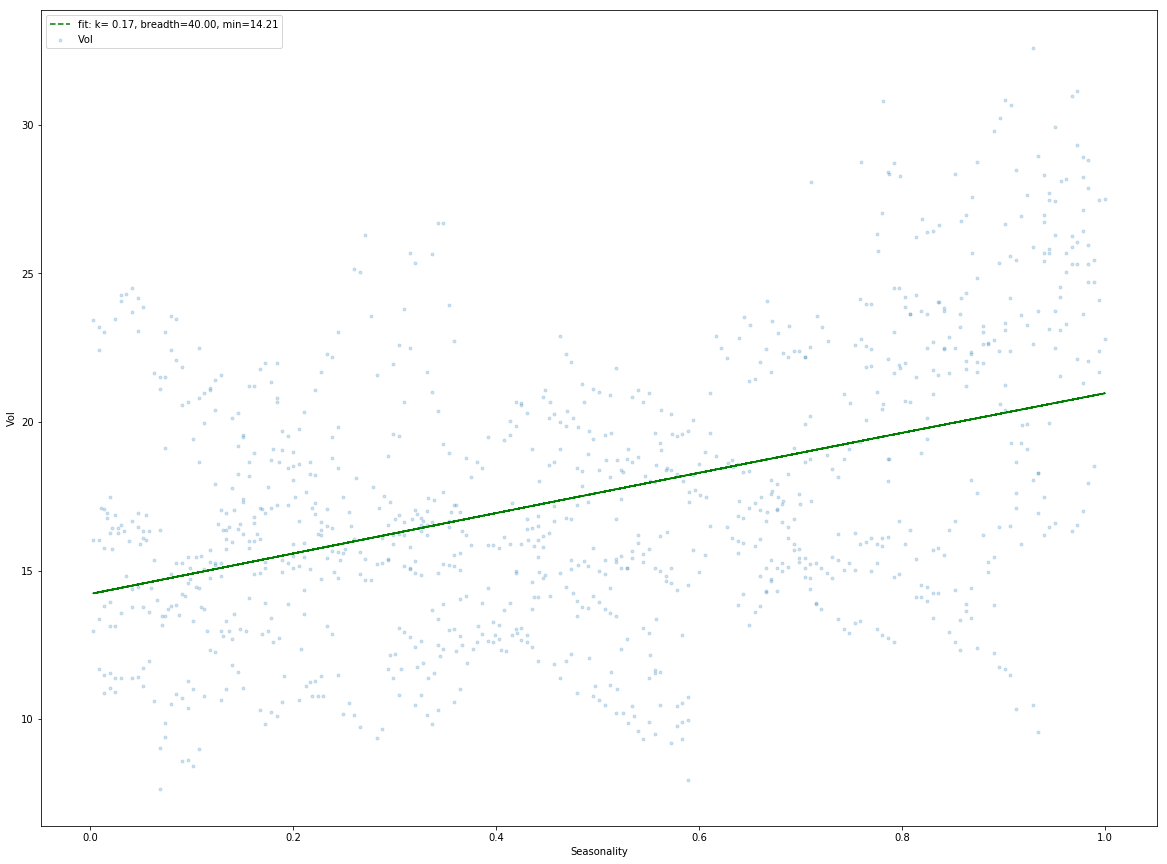

In [33]:
plt.figure(figsize=(20,15))
plt.scatter(recent_data['Seasonality'], recent_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, arc_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.xlabel('Seasonality')
plt.ylabel('Vol')
plt.legend()
plt.show()

In [34]:
recent_data.describe()

,Year,Vol,DTE,Seasonality
count,1045.000000,1045.000000,1045,1045.000000
mean,2016.813397,17.498861,31 days 03:47:22.105263,0.484326
std,1.343571,4.622618,15 days 18:03:13.608213,0.291271
min,2015.000000,7.660000,6 days 00:00:00,0.002740
25%,2016.000000,14.360000,18 days 00:00:00,0.221918
50%,2017.000000,16.600000,30 days 00:00:00,0.475410
75%,2018.000000,20.660000,45 days 00:00:00,0.742466
max,2019.000000,32.599999,60 days 00:00:00,1.000000


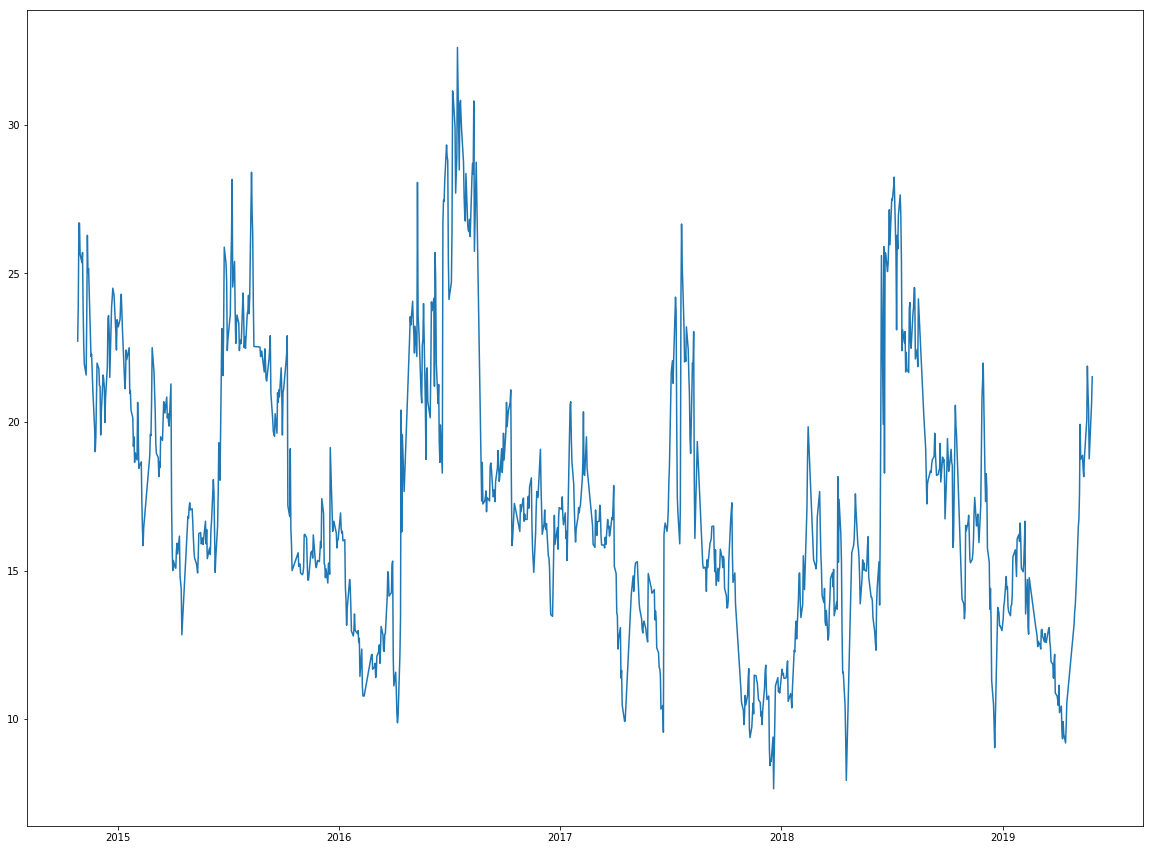

In [186]:
plt.figure(figsize=(20,15))
plt.plot(recent_data['Observation Date'],recent_data['Vol'])

In [36]:
print(len(recent_data))

1045


In [37]:
print(recent_data[750:800])

      Observation Date  Year    Vol     Expiry     DTE  Seasonality
37381       2018-02-05  2018  13.86 2018-02-20 15 days     0.194521
37398       2018-02-06  2018  15.50 2018-02-20 14 days     0.200000
37415       2018-02-08  2018  14.36 2018-02-20 12 days     0.210959
37432       2018-02-09  2018  15.06 2018-02-20 11 days     0.216438
37449       2018-02-12  2018  17.08 2018-02-20  8 days     0.232877
37466       2018-02-13  2018  18.78 2018-02-20  7 days     0.238356
37483       2018-02-14  2018  19.84 2018-02-20  6 days     0.243836
37636       2018-02-23  2018  15.36 2018-04-24 60 days     0.293151
37653       2018-02-26  2018  15.16 2018-04-24 57 days     0.309589
37670       2018-02-27  2018  15.06 2018-04-24 56 days     0.315068
37687       2018-02-28  2018  15.32 2018-04-24 55 days     0.320548
37704       2018-03-01  2018  16.78 2018-04-24 54 days     0.326027
37721       2018-03-02  2018  17.00 2018-04-24 53 days     0.331507
37738       2018-03-05  2018  17.66 2018-04-24 5

In [38]:
year_range = range(2014,2019)
df_by_year = []
for year in year_range:
    data = final_data[final_data['Year'] == year]
    df_by_year.append(data)

In [39]:
year_range = range(2014, 2019)
df_by_year = [final_data[final_data['Year'] == year] for year in year_range]

In [40]:
df_by_year

[      Observation Date  Year        Vol     Expiry     DTE  Seasonality
 18647       2013-10-28  2014  18.340000 2013-12-26 59 days     0.353425
 18664       2013-10-29  2014  17.980000 2013-12-26 58 days     0.347945
 18681       2013-10-30  2014  17.520000 2013-12-26 57 days     0.342466
 18698       2013-10-31  2014  17.800000 2013-12-26 56 days     0.336986
 18715       2013-11-01  2014  18.620000 2013-12-26 55 days     0.331507
 18732       2013-11-04  2014  18.340000 2013-12-26 52 days     0.315068
 18749       2013-11-05  2014  18.740000 2013-12-26 51 days     0.309589
 18766       2013-11-06  2014  18.540000 2013-12-26 50 days     0.304110
 18783       2013-11-07  2014  18.940000 2013-12-26 49 days     0.298630
 18800       2013-11-08  2014  15.880000 2013-12-26 48 days     0.293151
 18817       2013-11-11  2014  15.020000 2013-12-26 45 days     0.276712
 18834       2013-11-12  2014  15.020000 2013-12-26 44 days     0.271233
 18851       2013-11-13  2014  15.340000 2013-12-26

In [41]:
max_by_year = []
for i in df_by_year:
    stuff = i['Vol'].idxmax()
    max_by_year.append(i.loc[stuff])
print(max_by_year)

[Observation Date    2014-10-15 00:00:00
Year                               2014
Vol                                28.3
Expiry              2014-10-24 00:00:00
DTE                     9 days 00:00:00
Seasonality                    0.424658
Name: 23339, dtype: object, Observation Date    2015-08-10 00:00:00
Year                               2015
Vol                                28.4
Expiry              2015-08-21 00:00:00
DTE                    11 days 00:00:00
Seasonality                    0.786301
Name: 22132, dtype: object, Observation Date    2016-07-15 00:00:00
Year                               2016
Vol                                32.6
Expiry              2016-07-24 00:00:00
DTE                     9 days 00:00:00
Seasonality                    0.928962
Name: 26688, dtype: object, Observation Date    2017-07-20 00:00:00
Year                               2017
Vol                               26.66
Expiry              2017-08-21 00:00:00
DTE                    32 days 00:0

#### Creating a seasonally adjusted vol

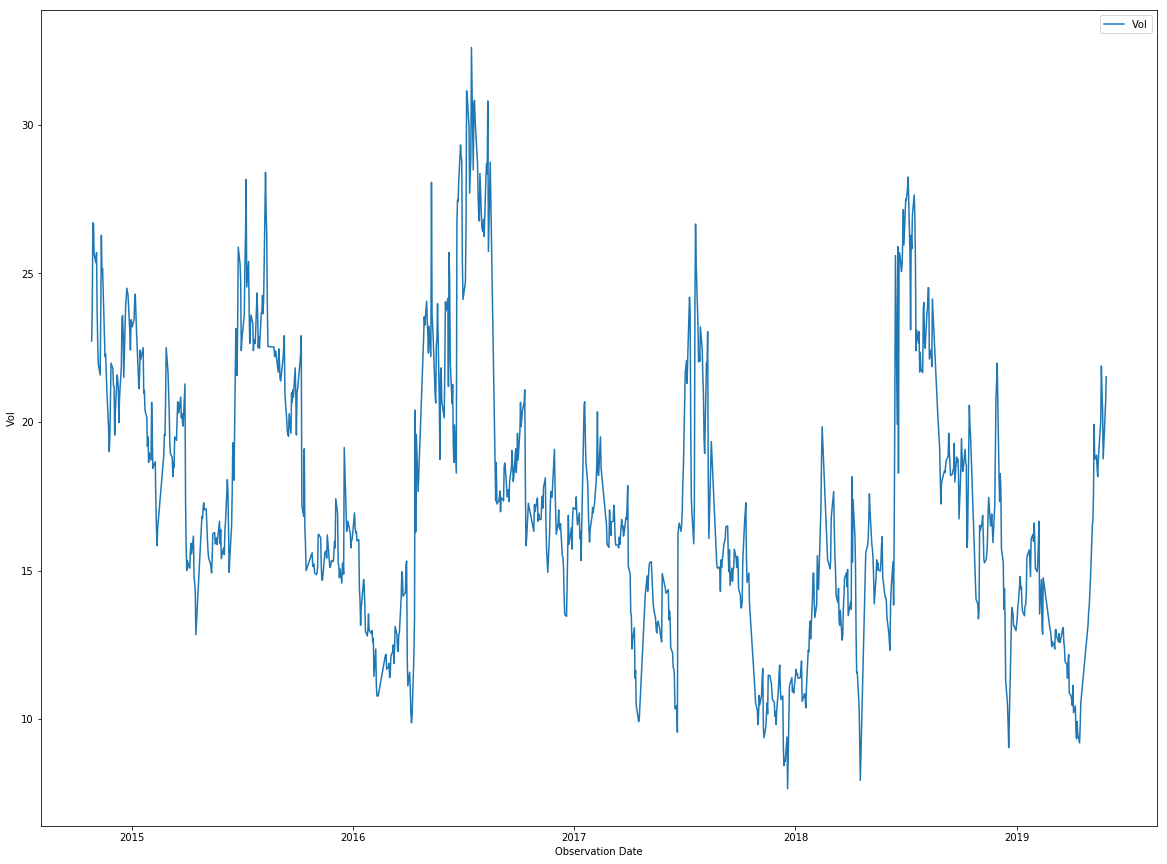

In [42]:
plt.figure(figsize=(20,15))
plt.plot(recent_data['Observation Date'], recent_data['Vol'])
plt.xlabel('Observation Date')
plt.ylabel('Vol')
plt.legend()
plt.show()

In [67]:
recent_data['Predicted Vol'] = recent_data.apply(lambda x: sig_fit(x['Seasonality'], *popt), axis=1)

recent_data['Adj Vol'] = recent_data['Vol'] - recent_data['Predicted Vol']

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
recent_data

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Predicted Vol,Adj Vol
22863,2014-10-27,2015,22.719999,2014-12-25,59 days,0.358904,16.752748,5.967251
22880,2014-10-28,2015,23.939999,2014-12-25,58 days,0.353425,16.716799,7.223201
22897,2014-10-29,2015,26.699999,2014-12-25,57 days,0.347945,16.680818,10.019181
22914,2014-10-30,2015,26.679999,2014-12-25,56 days,0.342466,16.644808,10.035191
22931,2014-10-31,2015,25.639999,2014-12-25,55 days,0.336986,16.608768,9.031231
22948,2014-11-03,2015,25.359999,2014-12-25,52 days,0.320548,16.500476,8.859524
22965,2014-11-04,2015,25.699999,2014-12-25,51 days,0.315068,16.464322,9.235677
22982,2014-11-05,2015,23.799999,2014-12-25,50 days,0.309589,16.428141,7.371859
22999,2014-11-06,2015,22.579999,2014-12-25,49 days,0.304110,16.391933,6.188067
23016,2014-11-07,2015,21.939999,2014-12-25,48 days,0.298630,16.355698,5.584302


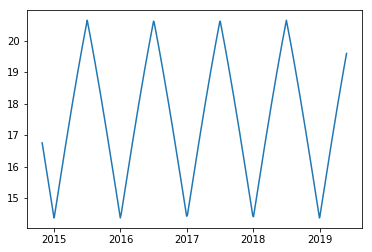

In [70]:
plt.plot(recent_data['Observation Date'], recent_data['Predicted Vol'])

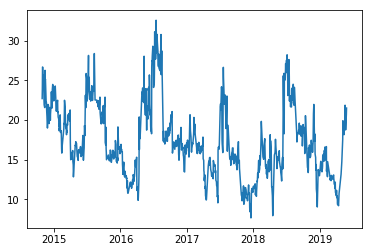

In [71]:
plt.plot(recent_data['Observation Date'], recent_data['Vol'])

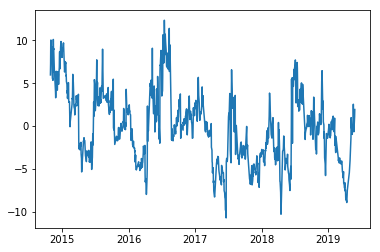

In [72]:
plt.plot(recent_data['Observation Date'], recent_data['Adj Vol'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A270BA8>]],
      dtype=object)

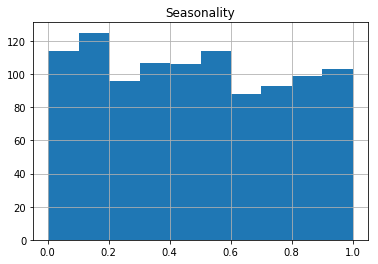

In [73]:
recent_data.hist(column='Seasonality')

In [74]:
recent_data.describe()

,Year,Vol,DTE,Seasonality,Predicted Vol,Adj Vol
count,1045.000000,1045.000000,1045,1045.000000,1045.000000,1045.000000
mean,2016.813397,17.498861,31 days 03:47:22.105263,0.484326,17.509544,-0.010684
std,1.343571,4.622618,15 days 18:03:13.608213,0.291271,1.845551,4.193811
min,2015.000000,7.660000,6 days 00:00:00,0.002740,14.372634,-10.720851
25%,2016.000000,14.360000,18 days 00:00:00,0.221918,15.845888,-3.272076
50%,2017.000000,16.600000,30 days 00:00:00,0.475410,17.509117,-0.231383
75%,2018.000000,20.660000,45 days 00:00:00,0.742466,19.169233,2.774192
max,2019.000000,32.599999,60 days 00:00:00,1.000000,20.644074,12.348754


In [75]:
# linear seasonality parameter reduces interquartile range by 0.26 between Vol and Adj Vol
# cosine seasonality parameter reduces interquartile range by 0.14 between Vol and Adj Vol

#### Second model

In [76]:
recent_data2 = final_data[final_data['Year'] > 2014]

In [77]:
def day_num(date):
    year = date.year
    start = pd.datetime(year-1,12,31)
    day = date - start
    return(day.days)

In [78]:
day_num(pd.datetime(2012,12,31))

366

In [79]:
recent_data2['Day Num'] = recent_data2.apply(lambda x: day_num(x['Observation Date']), axis=1)

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
recent_data2

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num
22863,2014-10-27,2015,22.719999,2014-12-25,59 days,0.358904,300
22880,2014-10-28,2015,23.939999,2014-12-25,58 days,0.353425,301
22897,2014-10-29,2015,26.699999,2014-12-25,57 days,0.347945,302
22914,2014-10-30,2015,26.679999,2014-12-25,56 days,0.342466,303
22931,2014-10-31,2015,25.639999,2014-12-25,55 days,0.336986,304
22948,2014-11-03,2015,25.359999,2014-12-25,52 days,0.320548,307
22965,2014-11-04,2015,25.699999,2014-12-25,51 days,0.315068,308
22982,2014-11-05,2015,23.799999,2014-12-25,50 days,0.309589,309
22999,2014-11-06,2015,22.579999,2014-12-25,49 days,0.304110,310
23016,2014-11-07,2015,21.939999,2014-12-25,48 days,0.298630,311


In [81]:
X = recent_data2['Day Num']
y = recent_data2['Vol']
degree = 15
coef = np.polyfit(X, y, degree)

In [82]:
coef

array([-1.66348450e-30,  4.56915522e-27, -5.64161851e-24,  4.13530413e-21,
       -2.00182022e-18,  6.73594935e-16, -1.61508662e-13,  2.78316931e-11,
       -3.43380623e-09,  2.98679206e-07, -1.78017521e-05,  6.94811621e-04,
       -1.65618324e-02,  2.15868623e-01, -1.28047801e+00,  1.84312506e+01])

In [83]:
curve = list()
for i in X:
    value = coef[0] * i**3 + coef[1] * i**2 + coef[2] * i**1 + coef[-1]
    curve.append(value)

In [84]:
curve = list()
for i in X:
    value = coef[-1]
    for d in range(degree):
        value += coef[d] * i**(degree-d)
    curve.append(value)

In [85]:
len(curve)

1045

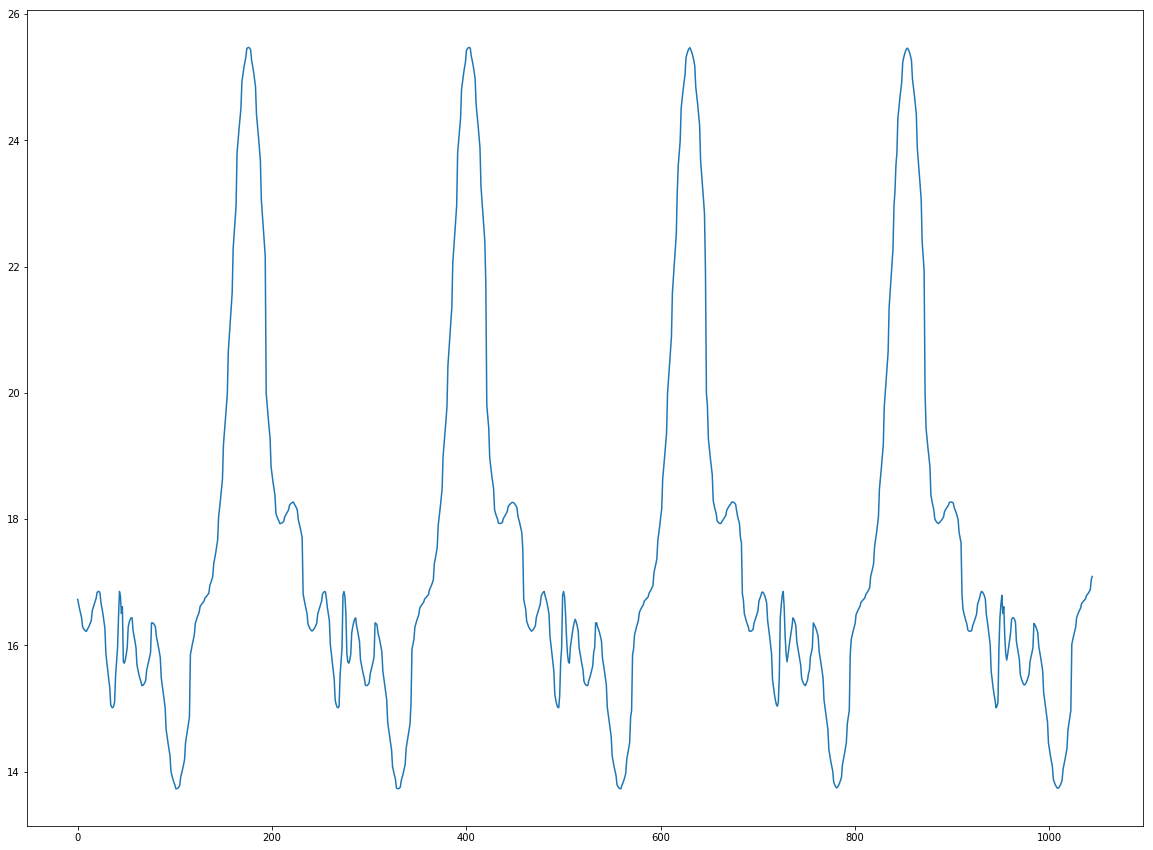

In [126]:
plt.figure(figsize=(20,15))
plt.plot(curve)

In [87]:
recent_data2['Curve'] = curve

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


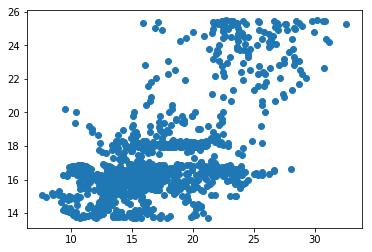

In [88]:
plt.scatter(recent_data2['Vol'], recent_data2['Curve'])

In [89]:
recent_data2['Adj Vol'] = recent_data2['Vol'] - recent_data2['Curve']

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


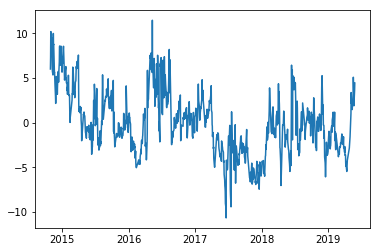

In [90]:
plt.plot(recent_data2['Observation Date'], recent_data2['Adj Vol'])

In [92]:
recent_data2['Vol Prev'] = recent_data2['Vol'].shift(1)

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
recent_data2['Vol Chg'] = recent_data2['Vol'] - recent_data2['Vol Prev']

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


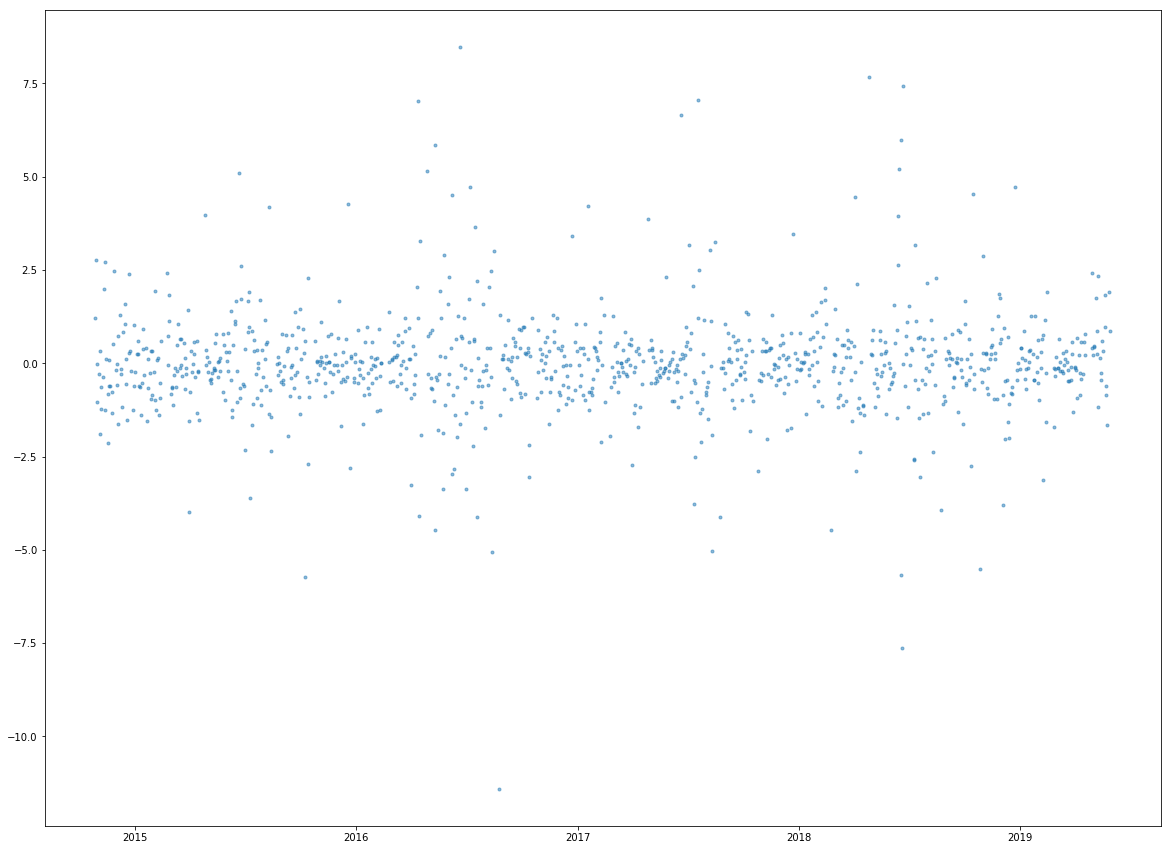

In [108]:
plt.figure(figsize=(20,15))
plt.plot_date(recent_data2['Observation Date'], recent_data2['Vol Chg'], alpha=0.5, marker='.')

In [137]:
recent_data2['Avg Vol'] = recent_data2['Vol'].rolling(10,1).mean()

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [130]:
recent_data2['Avg Vol Prev'] = recent_data2['Avg Vol'].shift(1)
recent_data2['Avg Vol Chg'] = recent_data2['Avg Vol'] - recent_data2['Avg Vol Prev']


C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


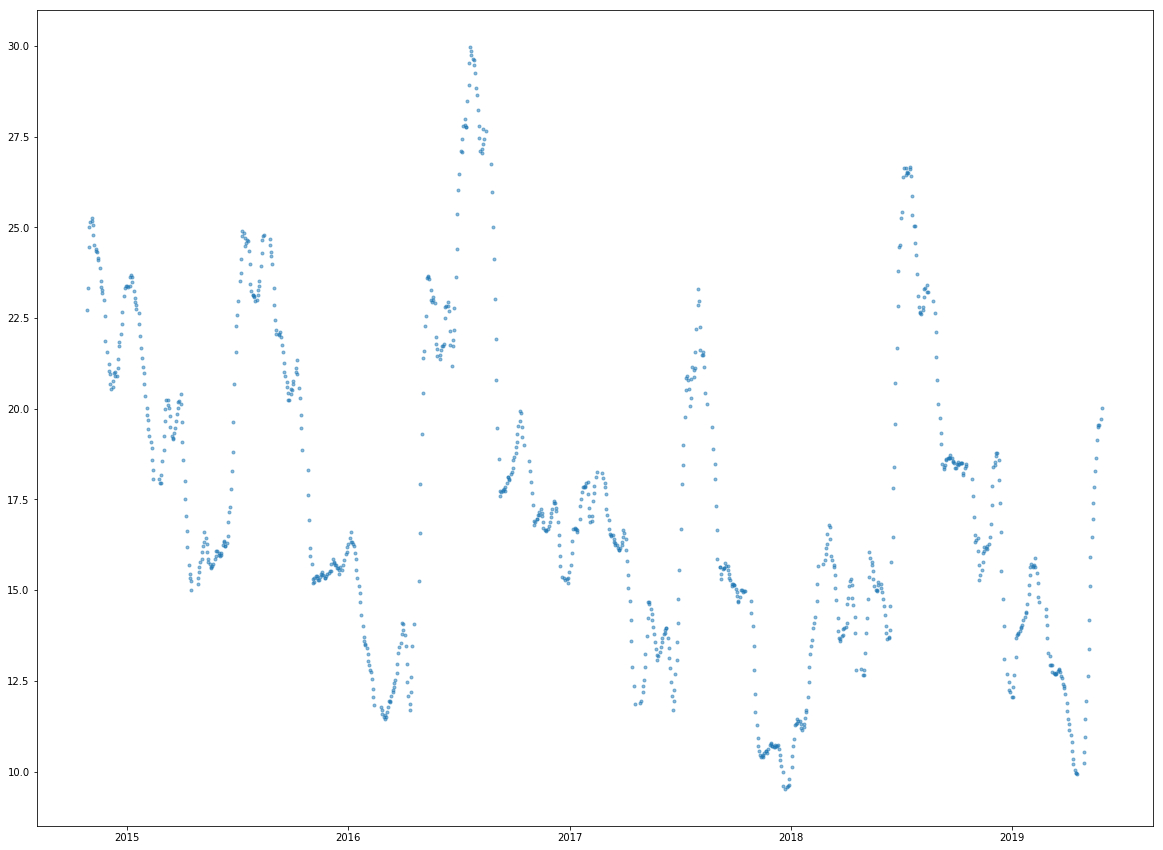

In [174]:
plt.figure(figsize=(20,15))
plt.plot_date(recent_data2['Observation Date'], recent_data2['Avg Vol'], alpha=0.5, marker='.')

In [138]:
recent_data2

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num,Curve,Adj Vol,Vol Prev,Vol Chg,Avg Vol,Avg Vol Prev,Avg Vol Chg
22863,2014-10-27,2015,22.719999,2014-12-25,59 days,0.358904,300,16.727356,5.992643,NaN,NaN,22.719999,NaN,NaN
22880,2014-10-28,2015,23.939999,2014-12-25,58 days,0.353425,301,16.647542,7.292457,22.719999,1.22,23.329999,NaN,NaN
22897,2014-10-29,2015,26.699999,2014-12-25,57 days,0.347945,302,16.572769,10.127230,23.939999,2.76,24.453333,NaN,NaN
22914,2014-10-30,2015,26.679999,2014-12-25,56 days,0.342466,303,16.503750,10.176249,26.699999,-0.02,25.009999,NaN,NaN
22931,2014-10-31,2015,25.639999,2014-12-25,55 days,0.336986,304,16.441151,9.198848,26.679999,-1.04,25.135999,NaN,NaN
22948,2014-11-03,2015,25.359999,2014-12-25,52 days,0.320548,307,16.297443,9.062557,25.639999,-0.28,25.173333,NaN,NaN
22965,2014-11-04,2015,25.699999,2014-12-25,51 days,0.315068,308,16.265672,9.434327,25.359999,0.34,25.248571,NaN,NaN
22982,2014-11-05,2015,23.799999,2014-12-25,50 days,0.309589,309,16.242444,7.557555,25.699999,-1.90,25.067499,NaN,NaN
22999,2014-11-06,2015,22.579999,2014-12-25,49 days,0.304110,310,16.227877,6.352123,23.799999,-1.22,24.791111,NaN,NaN
23016,2014-11-07,2015,21.939999,2014-12-25,48 days,0.298630,311,16.221973,5.718027,22.579999,-0.64,24.505999,NaN,NaN


In [124]:
recent_data2[recent_data2['Avg Vol Chg'] > 0.8]

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num,Curve,Adj Vol,Vol Prev,Vol Chg,Avg Vol,Avg Vol Prev,Avg Vol Chg
22676,2015-06-25,2015,23.279999,2015-07-24,29 days,0.961644,176,21.352003,1.927997,21.559999,1.72,19.644000,18.810000,0.834
22693,2015-06-26,2015,25.879999,2015-07-24,28 days,0.967123,177,21.586217,4.293783,23.279999,2.60,20.688000,19.644000,1.044
22710,2015-06-29,2015,25.319999,2015-07-24,25 days,0.983562,180,22.286419,3.033580,25.879999,-0.56,21.569999,20.688000,0.882
29935,2016-04-15,2016,19.580000,2016-04-24,9 days,0.573770,106,14.759399,4.820601,16.300000,3.28,13.462000,12.616000,0.846
30190,2016-04-27,2016,22.819999,2016-06-26,60 days,0.639344,118,15.937236,6.882764,17.660000,5.16,15.250000,14.070000,1.180
30207,2016-04-28,2016,23.539999,2016-06-26,59 days,0.644809,119,16.016620,7.523379,22.819999,0.72,16.584000,15.250000,1.334
30224,2016-04-29,2016,23.259999,2016-06-26,58 days,0.650273,120,16.091558,7.168442,23.539999,-0.28,17.922000,16.584000,1.338
30241,2016-05-02,2016,24.059999,2016-06-26,55 days,0.666667,123,16.288421,7.771578,23.259999,0.80,19.316000,17.922000,1.394
30258,2016-05-03,2016,23.399999,2016-06-26,54 days,0.672131,124,16.344567,7.055432,24.059999,-0.66,20.440000,19.316000,1.124
30275,2016-05-04,2016,22.999999,2016-06-26,53 days,0.677596,125,16.396028,6.603972,23.399999,-0.40,21.401999,20.440000,0.962


In [121]:
recent_data2[-0.75 > recent_data2['Avg Vol Chg']]

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num,Curve,Adj Vol,Vol Prev,Vol Chg,Avg Vol,Avg Vol Prev,Avg Vol Chg
27130,2015-10-29,2016,15.22,2015-12-25,57 days,0.347945,302,16.572769,-1.352770,15.200000,0.02,16.156000,16.924000,-0.768
30513,2016-05-24,2016,18.74,2016-06-26,33 days,0.786885,145,16.912488,1.827512,20.599999,-1.86,21.977999,22.909999,-0.932
31125,2016-08-24,2016,17.34,2016-10-23,60 days,0.710383,237,19.801576,-2.461577,28.739999,-11.40,26.739999,27.649999,-0.910
31142,2016-08-25,2016,18.64,2016-10-23,59 days,0.704918,238,19.618186,-0.978186,17.340000,1.30,25.963999,26.739999,-0.776
31159,2016-08-26,2016,17.24,2016-10-23,58 days,0.699454,239,19.442938,-2.202938,18.640000,-1.40,25.005999,25.963999,-0.958
31176,2016-08-29,2016,17.34,2016-10-23,55 days,0.683060,242,18.970602,-1.630602,17.240000,0.10,24.115999,25.005999,-0.890
31193,2016-08-30,2016,17.46,2016-10-23,54 days,0.677596,243,18.832177,-1.372177,17.340000,0.12,23.033999,24.115999,-1.082
31210,2016-08-31,2016,17.68,2016-10-23,53 days,0.672131,244,18.703715,-1.023715,17.460000,0.22,21.931999,23.033999,-1.102
31227,2016-09-01,2016,16.98,2016-10-23,52 days,0.666667,245,18.585390,-1.605390,17.680000,-0.70,20.796000,21.931999,-1.136
31244,2016-09-02,2016,17.46,2016-10-23,51 days,0.661202,246,18.477310,-1.017310,16.980000,0.48,19.462000,20.796000,-1.334


In [144]:
data_2015 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2015,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2015,1,1))]

In [147]:
data_2016 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2016,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2016,1,1))]
data_2017 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2017,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2017,1,1))]
data_2018 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2018,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2018,1,1))]

In [149]:
years = range(2014,2019)

In [151]:
for year in years:
    print(year)

2014
2015
2016
2017
2018


In [168]:
data_by_year = []
for year in years:
    data = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(year,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(year,1,1))]
    data = data[['Day Num','Vol']]
    data.set_index('Day Num', inplace=True)
    data_by_year.append(data)

In [169]:
data_by_year

[               Vol
 Day Num           
 300      22.719999
 301      23.939999
 302      26.699999
 303      26.679999
 304      25.639999
 307      25.359999
 308      25.699999
 309      23.799999
 310      22.579999
 311      21.939999
 314      21.579999
 315      23.579999
 316      26.279999
 317      25.039999
 318      25.159999
 321      23.019999
 322      22.199999
 323      22.279999
 324      21.679999
 325      21.079999
 328      19.760000
 329      19.000000
 330      19.520000
 332      21.979999
 335      21.789999
 336      21.219999
 337      21.199999
 338      19.560000
 339      20.300000
 342      21.579999
 343      21.419999
 344      21.139999
 345      19.980000
 346      20.820000
 349      21.859999
 350      23.459999
 351      23.579999
 352      23.019999
 353      21.499999
 356      23.879999
 357      24.159999
 358      24.499999
 360      24.279999
 363      23.019999
 364      22.419999
 365      23.439999,                Vol
 Day Num           


In [170]:
day_vols = data_by_year[0]
len(day_vols)

46

In [171]:
data_by_year[1]

,Vol
Day Num,
2,23.199999
5,23.459999
6,24.059999
7,24.299999
8,23.699999
9,23.059999
12,21.659999
13,21.119999
14,21.499999


In [172]:
day_vols.join(data_by_year[1], on='Day Num', rsuffix='_2015')

,Vol,Vol_2015
Day Num,,
300,22.719999,15.14
301,23.939999,15.20
302,26.699999,15.22
303,26.679999,14.92
304,25.639999,NaN
307,25.359999,14.92
308,25.699999,15.10
309,23.799999,16.20
310,22.579999,16.22


In [146]:
Xdata = data_2015['Day Num']
ydata = data_2015['Avg Vol']

cs = CubicSpline(Xdata, ydata, bc_type='periodic')

ValueError: The first and last `y` point along axis 0 must be identical (within machine precision) when bc_type='periodic'.

In [133]:
ydata

22863          NaN
22880          NaN
22897          NaN
22914          NaN
22931          NaN
22948          NaN
22965          NaN
22982          NaN
22999          NaN
23016    24.505999
23033    24.391999
23050    24.355999
23067    24.313999
23084    24.149999
23101    24.101999
23118    23.867999
23135    23.517999
23152    23.365999
23169    23.275999
23186    23.189999
23203    23.007999
23220    22.549999
23237    21.873999
23254    21.567999
23271    21.230999
23288    21.050999
23305    20.950999
23322    20.679000
23339    20.541000
23356    20.591000
           ...    
42345    10.828000
42362    10.568000
42379    10.342000
42396    10.204000
42413    10.046000
42430     9.958000
42447     9.966000
42464     9.928000
42753    10.224000
42770    10.540000
42787    10.962000
42804    11.456000
42821    11.936000
42838    12.632000
42855    13.384000
42872    14.166000
42889    15.104000
42906    15.902000
42923    16.472000
42940    16.954000
42957    17.388000
42974    17.

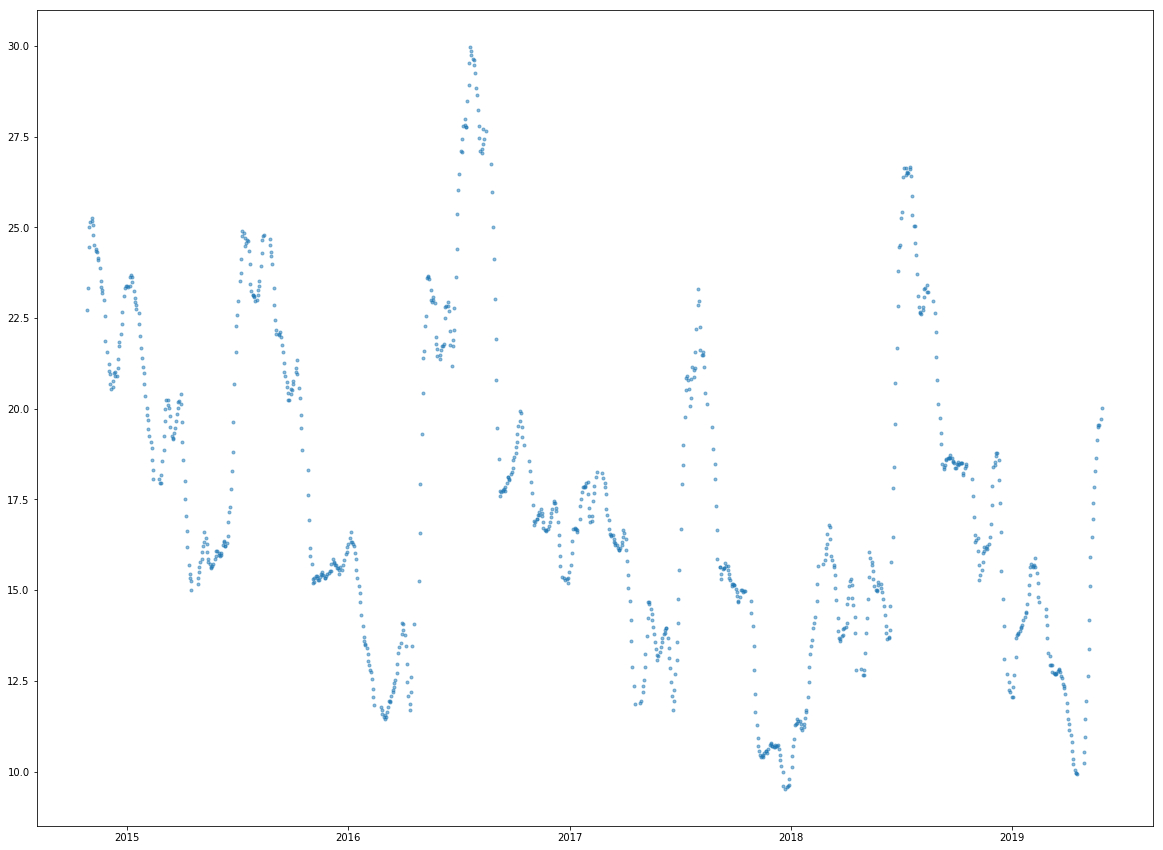

In [175]:
plt.figure(figsize=(20,15))
plt.plot_date(recent_data2['Observation Date'], recent_data2['Avg Vol'], alpha=0.5, marker='.')